In [1]:
import pandas as pd
import numpy as np
import os,sys
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import pandas_datareader.data as web
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')
# import sklearn
# import PyPortfolioOpt



symbol_data= pd.read_csv('../data/symbols.csv')
print(symbol_data.shape)
symbols_list = [ c+".NS" for c in symbol_data.Symbol.unique().tolist()]
end_date = '2024-05-14'
start_date = '2014-05-14'


symbol_data.head()


(501, 5)


,Company Name,Industry,Symbol,Series,ISIN Code
0,360 ONE WAM Ltd.,Financial Services,360ONE,EQ,INE466L01038
1,3M India Ltd.,Diversified,3MINDIA,EQ,INE470A01017
2,ABB India Ltd.,Capital Goods,ABB,EQ,INE117A01022
3,ACC Ltd.,Construction Materials,ACC,EQ,INE012A01025
4,AIA Engineering Ltd.,Capital Goods,AIAENG,EQ,INE212H01026


In [10]:
## Read data
df = yf.download(tickers=symbols_list,start=start_date,end=end_date)
stacked_df = df.stack()

print(stacked_df.shape)
stacked_df.head()

[*********************100%%**********************]  501 of 501 completed


(1007276, 6)


Price                       Adj Close        Close         High          Low  \
Date       Ticker                                                              
2014-05-14 3MINDIA.NS     3702.260742  3850.000000  3875.000000  3850.000000   
           AARTIIND.NS      33.505825    35.756599    36.497734    35.598656   
           ABB.NS          779.549927   809.673767   832.461060   804.544373   
           ABBOTINDIA.NS  1645.742554  1759.650024  1765.000000  1710.150024   
           ABFRL.NS        123.410545   123.410545   126.909805   118.679153   

Price                            Open    Volume  
Date       Ticker                                
2014-05-14 3MINDIA.NS     3874.850098     463.0  
           AARTIIND.NS      36.497734  111940.0  
           ABB.NS          829.283508   86513.0  
           ABBOTINDIA.NS  1718.000000    1584.0  
           ABFRL.NS        118.679153   60482.0

# Create Technical Indicators

- Garman Klass Volatality : https://derivvaluation.medium.com/garman-klass-volatility-calculation-volatility-analysis-in-python-333ca1d17376
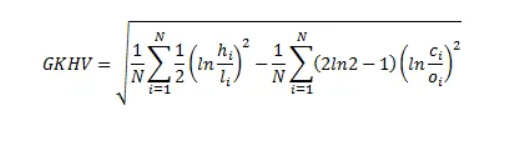 
- RSI : Relative Strength Index
- Bollinger Bands
- ATR
- MACD
- Price Volume

In [11]:
#ti_ stands for technical indicators
stacked_df['ti_garman_klass'] = ((np.log(stacked_df.High) - np.log(stacked_df.Low) )**2 )/2 - (2*np.log(2)-1) * (np.log(stacked_df.Close) - np.log(stacked_df.Open)) **2
stacked_df['ti_rsi'] = stacked_df.groupby(level=1 )['Adj Close'].transform(lambda x : pandas_ta.rsi(close=x , length=20)) #ticker level
stacked_df['ti_bb_low']  = stacked_df.groupby(level=1)['Adj Close'].transform(lambda x : pandas_ta.bbands(close=np.log1p(x),length=20).iloc[:,0])
stacked_df['ti_bb_mid']  = stacked_df.groupby(level=1)['Adj Close'].transform(lambda x : pandas_ta.bbands(close=np.log1p(x),length=20).iloc[:,1])
stacked_df['ti_bb_high']  = stacked_df.groupby(level=1)['Adj Close'].transform(lambda x : pandas_ta.bbands(close=np.log1p(x),length=20).iloc[:,2])


def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['High'],
                        low = stock_data['Low'],
                        close = stock_data['Close'],
                        length =14
                        )
    return atr.sub(atr.mean()).div(atr.std())


stacked_df['atr'] = stacked_df.groupby(level =1 ,group_keys=False).apply(compute_atr)


def compute_macd(close):
    macd  =pandas_ta.macd(close=close,length = 20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())


stacked_df['ti_macd'] = stacked_df.groupby(level = 1,group_keys=False)['Adj Close'].apply(compute_macd)

stacked_df['ti_rupee_volume_cr'] = (stacked_df['Adj Close'] * stacked_df['Volume']) / 10000000

stacked_df.columns = [c.lower().replace(" ","_") for c in stacked_df.columns] 


In [12]:
stacked_df.head()

adj_close        close         high          low  \
Date       Ticker                                                              
2014-05-14 3MINDIA.NS     3702.260742  3850.000000  3875.000000  3850.000000   
           AARTIIND.NS      33.505825    35.756599    36.497734    35.598656   
           ABB.NS          779.549927   809.673767   832.461060   804.544373   
           ABBOTINDIA.NS  1645.742554  1759.650024  1765.000000  1710.150024   
           ABFRL.NS        123.410545   123.410545   126.909805   118.679153   

                                 open    volume  ti_garman_klass  ti_rsi  \
Date       Ticker                                                          
2014-05-14 3MINDIA.NS     3874.850098     463.0         0.000005     NaN   
           AARTIIND.NS      36.497734  111940.0         0.000148     NaN   
           ABB.NS          829.283508   86513.0         0.000361     NaN   
           ABBOTINDIA.NS  1718.000000    1584.0         0.000277     NaN   
           ABFRL.NS        118.679153   60482.0         0.001658     NaN   

                          ti_bb_low  ti_bb_mid  ti_bb_high  atr  ti_macd  \
Date       Ticker                                                          
2014-05-14 3MINDIA.NS           NaN        NaN         NaN  NaN      NaN   
           AARTIIND.NS          NaN        NaN         NaN  NaN      NaN   
           ABB.NS               NaN        NaN         NaN  NaN      NaN   
           ABBOTINDIA.NS        NaN        NaN         NaN  NaN      NaN   
           ABFRL.NS             NaN        NaN         NaN  NaN      NaN   

                          ti_rupee_volume_cr  
Date       Ticker                             
2014-05-14 3MINDIA.NS               0.171415  
           AARTIIND.NS              0.375064  
           ABB.NS                   6.744120  
           ABBOTINDIA.NS            0.260686  
           ABFRL.NS                 0.746412

# Aggregate monthle level and filter top 200 liquid stocks



In [26]:
TOTAL_ANALYSIS_STOCKS = 200
stacked_df.head(2)

adj_close        close         high          low  \
Date       Ticker                                                            
2014-05-14 3MINDIA.NS   3702.260742  3850.000000  3875.000000  3850.000000   
           AARTIIND.NS    33.505825    35.756599    36.497734    35.598656   

                               open    volume  ti_garman_klass  ti_rsi  \
Date       Ticker                                                        
2014-05-14 3MINDIA.NS   3874.850098     463.0         0.000005     NaN   
           AARTIIND.NS    36.497734  111940.0         0.000148     NaN   

                        ti_bb_low  ti_bb_mid  ti_bb_high  atr  ti_macd  \
Date       Ticker                                                        
2014-05-14 3MINDIA.NS         NaN        NaN         NaN  NaN      NaN   
           AARTIIND.NS        NaN        NaN         NaN  NaN      NaN   

                        ti_rupee_volume_cr  
Date       Ticker                           
2014-05-14 3MINDIA.NS             0.171415  
           AARTIIND.NS            0.375064

In [33]:
last_cols = [ c for c in stacked_df.columns if c not in ['ti_rupee_volume_cr','high','volume','open','high','low','close']  ]
data = pd.concat( [ stacked_df.unstack('Ticker')['ti_rupee_volume_cr'].resample("M").mean().stack('Ticker').to_frame('ti_rupee_volume_cr'),
            stacked_df.unstack()[last_cols].resample('M').last().stack('Ticker')],axis=1 ).dropna()
print(data.shape)
data.head(10)

(49044, 9)


ti_rupee_volume_cr    adj_close       atr  \
Date       Ticker                                                     
2014-06-30 3MINDIA.NS               1.293476  4328.183105 -1.727959   
           AARTIIND.NS              1.574756    46.165867 -1.205183   
           ABB.NS                  11.889462   979.933044 -0.684015   
           ABBOTINDIA.NS            1.378222  2031.399658 -1.052868   
           ABFRL.NS                 0.216032   122.326271 -0.695501   
           ACC.NS                  43.666576  1297.589722  0.042075   
           ACE.NS                   0.894115    30.465019 -0.538052   
           ADANIENT.NS            119.160903    64.286888 -0.635274   
           ADANIPORTS.NS           91.639886   231.373520 -0.615724   
           ADANIPOWER.NS           48.780127    62.549999 -0.467189   

                          ti_bb_high  ti_bb_low  ti_bb_mid  ti_garman_klass  \
Date       Ticker                                                             
2014-06-30 3MINDIA.NS       8.407672   8.329407   8.368539         0.000196   
           AARTIIND.NS      3.909758   3.652099   3.780928         0.000788   
           ABB.NS           6.899589   6.693376   6.796483         0.000169   
           ABBOTINDIA.NS    7.630692   7.315716   7.473204         0.000420   
           ABFRL.NS         4.860739   4.732675   4.796707         0.000482   
           ACC.NS           7.200269   7.130154   7.165212         0.000440   
           ACE.NS           3.463673   3.165799   3.314736         0.000153   
           ADANIENT.NS      4.303483   4.137765   4.220624         0.000353   
           ADANIPORTS.NS    5.489991   5.360545   5.425268         0.000588   
           ADANIPOWER.NS    4.188275   4.066680   4.127478         0.000299   

                           ti_macd     ti_rsi  
Date       Ticker                              
2014-06-30 3MINDIA.NS     0.089514  61.524047  
           AARTIIND.NS    0.097096  70.488626  
           ABB.NS         0.552482  76.830642  
           ABBOTINDIA.NS  0.097213  82.753500  
           ABFRL.NS      -0.151240  50.467770  
           ACC.NS         0.446715  55.480516  
           ACE.NS        -0.262889  66.250809  
           ADANIENT.NS   -0.170721  42.244156  
           ADANIPORTS.NS -0.047852  57.231653  
           ADANIPOWER.NS -0.201392  59.297889

In [34]:
data['ti_rupee_volume_cr'] =( data['ti_rupee_volume_cr'].unstack('Ticker').rolling(5*12).mean().stack()) 
data['ti_rupee_volume_cr_rank'] = data.groupby('Date')['ti_rupee_volume_cr'].rank(ascending=False)
data=data[data['ti_rupee_volume_cr_rank']<TOTAL_ANALYSIS_STOCKS].drop(['ti_rupee_volume_cr','ti_rupee_volume_cr_rank'],axis=1)
print(data.shape)
data.head()

(12139, 8)


adj_close       atr  ti_bb_high  ti_bb_low  \
Date       Ticker                                                        
2019-05-31 ABB.NS         1394.313721 -0.302069    7.280224   7.057555   
           ABFRL.NS        207.934937  0.513099    5.380158   5.250258   
           ACC.NS         1599.940063  0.052904    7.422144   7.275940   
           ADANIENT.NS     152.917084 -0.523862    5.179378   4.656223   
           ADANIPORTS.NS   403.244904 -0.174138    6.028076   5.827573   

                          ti_bb_mid  ti_garman_klass   ti_macd     ti_rsi  
Date       Ticker                                                          
2019-05-31 ABB.NS          7.168890         0.000263  0.474502  65.242122  
           ABFRL.NS        5.315208         0.000916 -0.175541  50.473298  
           ACC.NS          7.349042         0.000321  0.699009  55.973540  
           ADANIENT.NS     4.917801         0.001968 -0.029211  60.199846  
           ADANIPORTS.NS   5.927824         0.000184  0.417867  62.021436

# Calculate Monthly time returns at different lag values

In [41]:
# g = stacked_df.xs('ADANIENT.NS',level=1)
# # 


def calculate_returns(df):
    outlier_cutoff = .005

    lags = [1,2,3,6,9,12]

    for lag in lags :
        df[f'return_{lag}m'] = (df['adj_close']
                            .pct_change(lag)
                            .pipe(lambda x : x.clip(lower=x.quantile(outlier_cutoff),
                                                        upper = x.quantile(1-outlier_cutoff)
                                    
                                                )
                            
                            
                            ).add(1).pow(1/lag).sub(1))

    return df 


data = data.groupby(level=1,group_keys=False).apply(calculate_returns)
data

adj_close       atr  ti_bb_high  ti_bb_low  \
Date       Ticker                                                        
2019-05-31 ABB.NS         1394.313721 -0.302069    7.280224   7.057555   
           ABFRL.NS        207.934937  0.513099    5.380158   5.250258   
           ACC.NS         1599.940063  0.052904    7.422144   7.275940   
           ADANIENT.NS     152.917084 -0.523862    5.179378   4.656223   
           ADANIPORTS.NS   403.244904 -0.174138    6.028076   5.827573   
...                               ...       ...         ...        ...   
2024-05-31 VOLTAS.NS      1301.849976  3.183565    7.336269   7.114093   
           WIPRO.NS        451.950012  0.582245    6.156698   6.103557   
           YESBANK.NS       22.250000 -0.858471    3.343376   3.128346   
           ZEEL.NS         129.800003 -1.545057    5.036839   4.872436   
           ZYDUSLIFE.NS    992.500000  4.894839    6.926106   6.820002   

                          ti_bb_mid  ti_garman_klass   ti_macd     ti_rsi  \
Date       Ticker                                                           
2019-05-31 ABB.NS          7.168890         0.000263  0.474502  65.242122   
           ABFRL.NS        5.315208         0.000916 -0.175541  50.473298   
           ACC.NS          7.349042         0.000321  0.699009  55.973540   
           ADANIENT.NS     4.917801         0.001968 -0.029211  60.199846   
           ADANIPORTS.NS   5.927824         0.000184  0.417867  62.021436   
...                             ...              ...       ...        ...   
2024-05-31 VOLTAS.NS       7.225181         0.000799  1.608330  51.578373   
           WIPRO.NS        6.130127         0.000169 -1.114977  38.648016   
           YESBANK.NS      3.235861         0.000449 -0.042792  39.539677   
           ZEEL.NS         4.954638         0.000237 -0.560246  35.441959   
           ZYDUSLIFE.NS    6.873054         0.000359  0.556925  54.863890   

                          return_1m  return_2m  return_3m  return_6m  \
Date       Ticker                                                      
2019-05-31 ABB.NS               NaN        NaN        NaN        NaN   
           ABFRL.NS             NaN        NaN        NaN        NaN   
           ACC.NS               NaN        NaN        NaN        NaN   
           ADANIENT.NS          NaN        NaN        NaN        NaN   
           ADANIPORTS.NS        NaN        NaN        NaN        NaN   
...                             ...        ...        ...        ...   
2024-05-31 VOLTAS.NS      -0.117240   0.086137   0.054865   0.078349   
           WIPRO.NS       -0.022599  -0.029760  -0.044818   0.015474   
           YESBANK.NS     -0.149140  -0.020688  -0.030941   0.023548   
           ZEEL.NS        -0.116706  -0.032092  -0.069190  -0.105328   
           ZYDUSLIFE.NS    0.040847  -0.007398   0.017596   0.076555   

                          return_9m  return_12m  
Date       Ticker                                
2019-05-31 ABB.NS               NaN         NaN  
           ABFRL.NS             NaN         NaN  
           ACC.NS               NaN         NaN  
           ADANIENT.NS          NaN         NaN  
           ADANIPORTS.NS        NaN         NaN  
...                             ...         ...  
2024-05-31 VOLTAS.NS       0.045814    0.039587  
           WIPRO.NS        0.011561    0.009642  
           YESBANK.NS      0.031711    0.026797  
           ZEEL.NS        -0.075150   -0.033369  
           ZYDUSLIFE.NS    0.052570    0.059213  

[12139 rows x 14 columns]

### FAMA French Factors 
- Market Premium: The market has been volatile with a negative performance last month but strong returns over three months and year to date. Long-term average shows a modest premium.
- SMB: Small-cap stocks have significantly underperformed large-cap stocks recently and modestly since 1994.
- HML: Value stocks have outperformed growth stocks, especially in the short term, and have a historical premium.
- WML: Momentum strategy (buying winners and selling losers) has been very profitable recently and has historically provided strong returns.

In [94]:
fama_values = pd.read_csv('../data/2024-03_FourFactors_and_Market_Returns_Monthly_SurvivorshipBiasAdjusted.csv')
print(fama_values.describe())
fama_values.rename(columns={'date':'Date'},inplace=True)
fama_values.set_index('Date',inplace=True)
fama_values.drop(columns=['year_mo'],axis=1)
fama_values.columns = ['fama_'+c for c in fama_values.columns]
fama_values.index = pd.to_datetime(fama_values.index) 
fama_values = fama_values.join(data['return_1m']).sort_index()
fama_values.head()

              SMB         HML         WML          MF          RF
count  365.000000  365.000000  365.000000  365.000000  365.000000
mean    -0.258080    0.763237    1.221841    0.756863    0.562418
std      4.897993    5.965389    7.198649    7.287062    0.168266
min    -14.606959  -19.297415  -27.256042  -29.279763    0.234628
25%     -3.269300   -3.050659   -2.389445   -3.217507    0.456202
50%      0.056461    0.273000    1.256681    0.884317    0.556886
75%      2.648915    3.868473    4.984666    4.951909    0.669264
max     13.684129   24.281835   33.938105   34.715798    1.107692


fama_year_mo  fama_SMB  fama_HML  fama_WML   fama_MF  \
Date       Ticker                                                               
2019-05-31 ABB.NS             2019-05  1.799978 -1.270011  2.509958 -0.970713   
           ABFRL.NS           2019-05  1.799978 -1.270011  2.509958 -0.970713   
           ACC.NS             2019-05  1.799978 -1.270011  2.509958 -0.970713   
           ADANIENT.NS        2019-05  1.799978 -1.270011  2.509958 -0.970713   
           ADANIPORTS.NS      2019-05  1.799978 -1.270011  2.509958 -0.970713   

                           fama_RF  return_1m  
Date       Ticker                              
2019-05-31 ABB.NS         0.528146        NaN  
           ABFRL.NS       0.528146        NaN  
           ACC.NS         0.528146        NaN  
           ADANIENT.NS    0.528146        NaN  
           ADANIPORTS.NS  0.528146        NaN

In [95]:
fama_values.xs('YESBANK.NS',level=1).tail()

,fama_year_mo,fama_SMB,fama_HML,fama_WML,fama_MF,fama_RF,return_1m
Date,,,,,,,
2023-11-30,2023-11,-1.334004,5.386864,4.922749,7.333399,0.552299,0.213166
2023-12-31,2023-12,-4.613219,3.777356,-1.607645,7.975653,0.535446,0.108527
2024-01-31,2024-01,1.633428,10.257069,5.926599,4.037570,0.609650,0.123543
2024-02-29,2024-02,-5.081382,0.427692,3.265015,1.643205,0.540849,0.014523
2024-03-31,2024-03,-7.800638,0.986218,2.436203,-0.808505,0.512871,-0.051125


In [96]:
## Remove stocs with less than 10 months of data
observe_size = fama_values.groupby(level=1).size()


valid_stocks = observe_size[observe_size>= 10]

print(observe_size.shape , valid_stocks.shape)


fama_values_ = fama_values[fama_values.index.get_level_values('Ticker').isin(valid_stocks.index)]

fama_values_.shape,fama_values.shape

(255,) (238,)


((11655, 7), (11741, 7))

In [85]:
# fama_values_.index = fama_values_.index.set_levels([pd.to_datetime(fama_values_.index.levels[0])] + list(fama_values_.index.levels[1:]))


In [97]:
fama_values_.head()

fama_year_mo  fama_SMB  fama_HML  fama_WML   fama_MF  \
Date       Ticker                                                               
2019-05-31 ABB.NS             2019-05  1.799978 -1.270011  2.509958 -0.970713   
           ABFRL.NS           2019-05  1.799978 -1.270011  2.509958 -0.970713   
           ACC.NS             2019-05  1.799978 -1.270011  2.509958 -0.970713   
           ADANIENT.NS        2019-05  1.799978 -1.270011  2.509958 -0.970713   
           ADANIPORTS.NS      2019-05  1.799978 -1.270011  2.509958 -0.970713   

                           fama_RF  return_1m  
Date       Ticker                              
2019-05-31 ABB.NS         0.528146        NaN  
           ABFRL.NS       0.528146        NaN  
           ACC.NS         0.528146        NaN  
           ADANIENT.NS    0.528146        NaN  
           ADANIPORTS.NS  0.528146        NaN

## Calculate Rolling Factor Betas

In [98]:
# fama_values_.index= pd.to_datetime(fama_values_.index)
fama_values_.drop(columns=['fama_year_mo'],inplace=True)

In [102]:
fama_values_ = fama_values_.replace({None: np.nan})
# fama_values_.dropna(inplace=True)
betas = (fama_values_.groupby(level=1,group_keys=False).apply(lambda x : RollingOLS(endog=x['return_1m'],
                                                                           exog = sm.add_constant(x.drop('return_1m',axis=1)),
                                                                           window=min(24 , x.shape[0]), # 2years data
                                                                           min_nobs=len(x.columns)+1).fit(params_only=True).params.drop('const',axis=1)))

In [107]:
data_new  = data.join(betas.groupby('Ticker').shift())
data_new

adj_close       atr  ti_bb_high  ti_bb_low  \
Date       Ticker                                                        
2019-05-31 ABB.NS         1394.313721 -0.302069    7.280224   7.057555   
           ABFRL.NS        207.934937  0.513099    5.380158   5.250258   
           ACC.NS         1599.940063  0.052904    7.422144   7.275940   
           ADANIENT.NS     152.917084 -0.523862    5.179378   4.656223   
           ADANIPORTS.NS   403.244904 -0.174138    6.028076   5.827573   
...                               ...       ...         ...        ...   
2024-05-31 VOLTAS.NS      1301.849976  3.183565    7.336269   7.114093   
           WIPRO.NS        451.950012  0.582245    6.156698   6.103557   
           YESBANK.NS       22.250000 -0.858471    3.343376   3.128346   
           ZEEL.NS         129.800003 -1.545057    5.036839   4.872436   
           ZYDUSLIFE.NS    992.500000  4.894839    6.926106   6.820002   

                          ti_bb_mid  ti_garman_klass   ti_macd     ti_rsi  \
Date       Ticker                                                           
2019-05-31 ABB.NS          7.168890         0.000263  0.474502  65.242122   
           ABFRL.NS        5.315208         0.000916 -0.175541  50.473298   
           ACC.NS          7.349042         0.000321  0.699009  55.973540   
           ADANIENT.NS     4.917801         0.001968 -0.029211  60.199846   
           ADANIPORTS.NS   5.927824         0.000184  0.417867  62.021436   
...                             ...              ...       ...        ...   
2024-05-31 VOLTAS.NS       7.225181         0.000799  1.608330  51.578373   
           WIPRO.NS        6.130127         0.000169 -1.114977  38.648016   
           YESBANK.NS      3.235861         0.000449 -0.042792  39.539677   
           ZEEL.NS         4.954638         0.000237 -0.560246  35.441959   
           ZYDUSLIFE.NS    6.873054         0.000359  0.556925  54.863890   

                          return_1m  return_2m  return_3m  return_6m  \
Date       Ticker                                                      
2019-05-31 ABB.NS               NaN        NaN        NaN        NaN   
           ABFRL.NS             NaN        NaN        NaN        NaN   
           ACC.NS               NaN        NaN        NaN        NaN   
           ADANIENT.NS          NaN        NaN        NaN        NaN   
           ADANIPORTS.NS        NaN        NaN        NaN        NaN   
...                             ...        ...        ...        ...   
2024-05-31 VOLTAS.NS      -0.117240   0.086137   0.054865   0.078349   
           WIPRO.NS       -0.022599  -0.029760  -0.044818   0.015474   
           YESBANK.NS     -0.149140  -0.020688  -0.030941   0.023548   
           ZEEL.NS        -0.116706  -0.032092  -0.069190  -0.105328   
           ZYDUSLIFE.NS    0.040847  -0.007398   0.017596   0.076555   

                          return_9m  return_12m  fama_SMB  fama_HML  fama_WML  \
Date       Ticker                                                               
2019-05-31 ABB.NS               NaN         NaN       NaN       NaN       NaN   
           ABFRL.NS             NaN         NaN       NaN       NaN       NaN   
           ACC.NS               NaN         NaN       NaN       NaN       NaN   
           ADANIENT.NS          NaN         NaN       NaN       NaN       NaN   
           ADANIPORTS.NS        NaN         NaN       NaN       NaN       NaN   
...                             ...         ...       ...       ...       ...   
2024-05-31 VOLTAS.NS       0.045814    0.039587       NaN       NaN       NaN   
           WIPRO.NS        0.011561    0.009642       NaN       NaN       NaN   
           YESBANK.NS      0.031711    0.026797       NaN       NaN       NaN   
           ZEEL.NS        -0.075150   -0.033369       NaN       NaN       NaN   
           ZYDUSLIFE.NS    0.052570    0.059213       NaN       NaN       NaN   

                          fama_MF  fama_RF  
Date       Ticker          

In [110]:
factors = ['fama_SMB'	,'fama_HML'	,'fama_WML'	,'fama_MF',	'fama_RF']
data_new.loc[:,factors] = data_new.groupby('Ticker',group_keys=False)[factors].apply(lambda x : x.fillna(x.mean()))
data_new

adj_close       atr  ti_bb_high  ti_bb_low  \
Date       Ticker                                                        
2019-05-31 ABB.NS         1394.313721 -0.302069    7.280224   7.057555   
           ABFRL.NS        207.934937  0.513099    5.380158   5.250258   
           ACC.NS         1599.940063  0.052904    7.422144   7.275940   
           ADANIENT.NS     152.917084 -0.523862    5.179378   4.656223   
           ADANIPORTS.NS   403.244904 -0.174138    6.028076   5.827573   
...                               ...       ...         ...        ...   
2024-05-31 VOLTAS.NS      1301.849976  3.183565    7.336269   7.114093   
           WIPRO.NS        451.950012  0.582245    6.156698   6.103557   
           YESBANK.NS       22.250000 -0.858471    3.343376   3.128346   
           ZEEL.NS         129.800003 -1.545057    5.036839   4.872436   
           ZYDUSLIFE.NS    992.500000  4.894839    6.926106   6.820002   

                          ti_bb_mid  ti_garman_klass   ti_macd     ti_rsi  \
Date       Ticker                                                           
2019-05-31 ABB.NS          7.168890         0.000263  0.474502  65.242122   
           ABFRL.NS        5.315208         0.000916 -0.175541  50.473298   
           ACC.NS          7.349042         0.000321  0.699009  55.973540   
           ADANIENT.NS     4.917801         0.001968 -0.029211  60.199846   
           ADANIPORTS.NS   5.927824         0.000184  0.417867  62.021436   
...                             ...              ...       ...        ...   
2024-05-31 VOLTAS.NS       7.225181         0.000799  1.608330  51.578373   
           WIPRO.NS        6.130127         0.000169 -1.114977  38.648016   
           YESBANK.NS      3.235861         0.000449 -0.042792  39.539677   
           ZEEL.NS         4.954638         0.000237 -0.560246  35.441959   
           ZYDUSLIFE.NS    6.873054         0.000359  0.556925  54.863890   

                          return_1m  return_2m  return_3m  return_6m  \
Date       Ticker                                                      
2019-05-31 ABB.NS               NaN        NaN        NaN        NaN   
           ABFRL.NS             NaN        NaN        NaN        NaN   
           ACC.NS               NaN        NaN        NaN        NaN   
           ADANIENT.NS          NaN        NaN        NaN        NaN   
           ADANIPORTS.NS        NaN        NaN        NaN        NaN   
...                             ...        ...        ...        ...   
2024-05-31 VOLTAS.NS      -0.117240   0.086137   0.054865   0.078349   
           WIPRO.NS       -0.022599  -0.029760  -0.044818   0.015474   
           YESBANK.NS     -0.149140  -0.020688  -0.030941   0.023548   
           ZEEL.NS        -0.116706  -0.032092  -0.069190  -0.105328   
           ZYDUSLIFE.NS    0.040847  -0.007398   0.017596   0.076555   

                          return_9m  return_12m  fama_SMB  fama_HML  fama_WML  \
Date       Ticker                                                               
2019-05-31 ABB.NS               NaN         NaN  0.005566  0.010734  0.013078   
           ABFRL.NS             NaN         NaN  0.005443  0.002331  0.002946   
           ACC.NS               NaN         NaN  0.002682  0.000135  0.001601   
           ADANIENT.NS          NaN         NaN  0.000181 -0.001833  0.004408   
           ADANIPORTS.NS        NaN         NaN -0.004643  0.001109 -0.000334   
...                             ...         ...       ...       ...       ...   
2024-05-31 VOLTAS.NS       0.045814    0.039587  0.000668  0.001921 -0.002250   
           WIPRO.NS        0.011561    0.009642  0.001167 -0.003199  0.004888   
           YESBANK.NS      0.031711    0.026797  0.002037  0.004701 -0.009432   
           ZEEL.NS        -0.075150   -0.033369  0.003161  0.002154 -0.005872   
           ZYDUSLIFE.NS    0.052570    0.059213 -0.000276  0.001584  0.000380   

                           fama_MF   fama_RF  
Date       Ticker        

In [113]:
return_cols = [c for c in data_new.columns if c.startswith('return_')]
data_new.loc[:,return_cols] = data_new.groupby('Ticker',group_keys=False)[return_cols].apply(lambda x : x.fillna(x.mean()))

data_new = data_new.dropna()

In [114]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11505 entries, (Timestamp('2019-05-31 00:00:00'), 'ABB.NS') to (Timestamp('2024-05-31 00:00:00'), 'ZYDUSLIFE.NS')
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   adj_close        11505 non-null  float64
 1   atr              11505 non-null  float64
 2   ti_bb_high       11505 non-null  float64
 3   ti_bb_low        11505 non-null  float64
 4   ti_bb_mid        11505 non-null  float64
 5   ti_garman_klass  11505 non-null  float64
 6   ti_macd          11505 non-null  float64
 7   ti_rsi           11505 non-null  float64
 8   return_1m        11505 non-null  float64
 9   return_2m        11505 non-null  float64
 10  return_3m        11505 non-null  float64
 11  return_6m        11505 non-null  float64
 12  return_9m        11505 non-null  float64
 13  return_12m       11505 non-null  float64
 14  fama_SMB         11505 non-null  float64
 15  fama_HML        

In [115]:
data_new= data_new.drop('adj_close',axis=1)

In [116]:
data_new

atr  ti_bb_high  ti_bb_low  ti_bb_mid  \
Date       Ticker                                                      
2019-05-31 ABB.NS        -0.302069    7.280224   7.057555   7.168890   
           ABFRL.NS       0.513099    5.380158   5.250258   5.315208   
           ACC.NS         0.052904    7.422144   7.275940   7.349042   
           ADANIENT.NS   -0.523862    5.179378   4.656223   4.917801   
           ADANIPORTS.NS -0.174138    6.028076   5.827573   5.927824   
...                            ...         ...        ...        ...   
2024-05-31 VOLTAS.NS      3.183565    7.336269   7.114093   7.225181   
           WIPRO.NS       0.582245    6.156698   6.103557   6.130127   
           YESBANK.NS    -0.858471    3.343376   3.128346   3.235861   
           ZEEL.NS       -1.545057    5.036839   4.872436   4.954638   
           ZYDUSLIFE.NS   4.894839    6.926106   6.820002   6.873054   

                          ti_garman_klass   ti_macd     ti_rsi  return_1m  \
Date       Ticker                                                           
2019-05-31 ABB.NS                0.000263  0.474502  65.242122   0.051067   
           ABFRL.NS              0.000916 -0.175541  50.473298   0.010323   
           ACC.NS                0.000321  0.699009  55.973540   0.010506   
           ADANIENT.NS           0.001968 -0.029211  60.199846   0.066915   
           ADANIPORTS.NS         0.000184  0.417867  62.021436   0.024466   
...                                   ...       ...        ...        ...   
2024-05-31 VOLTAS.NS             0.000799  1.608330  51.578373  -0.117240   
           WIPRO.NS              0.000169 -1.114977  38.648016  -0.022599   
           YESBANK.NS            0.000449 -0.042792  39.539677  -0.149140   
           ZEEL.NS               0.000237 -0.560246  35.441959  -0.116706   
           ZYDUSLIFE.NS          0.000359  0.556925  54.863890   0.040847   

                          return_2m  return_3m  return_6m  return_9m  \
Date       Ticker                                                      
2019-05-31 ABB.NS          0.045968   0.045388   0.042815   0.042359   
           ABFRL.NS        0.007704   0.005122   0.003960   0.002439   
           ACC.NS          0.010156   0.009677   0.009676   0.008731   
           ADANIENT.NS     0.062126   0.061452   0.060177   0.058039   
           ADANIPORTS.NS   0.023332   0.023391   0.022863   0.021286   
...                             ...        ...        ...        ...   
2024-05-31 VOLTAS.NS       0.086137   0.054865   0.078349   0.045814   
           WIPRO.NS       -0.029760  -0.044818   0.015474   0.011561   
           YESBANK.NS     -0.020688  -0.030941   0.023548   0.031711   
           ZEEL.NS        -0.032092  -0.069190  -0.105328  -0.075150   
           ZYDUSLIFE.NS   -0.007398   0.017596   0.076555   0.052570   

                          return_12m  fama_SMB  fama_HML  fama_WML   fama_MF  \
Date       Ticker                                                              
2019-05-31 ABB.NS           0.046791  0.005566  0.010734  0.013078  0.012186   
           ABFRL.NS         0.003422  0.005443  0.002331  0.002946  0.007297   
           ACC.NS           0.009804  0.002682  0.000135  0.001601  0.007385   
           ADANIENT.NS      0.060448  0.000181 -0.001833  0.004408  0.017860   
           ADANIPORTS.NS    0.021890 -0.004643  0.001109 -0.000334  0.014560   
...                              ...       ...       ...       ...       ...   
2024-05-31 VOLTAS.NS        0.039587  0.000668  0.001921 -0.002250  0.005126   
           WIPRO.NS         0.009642  0.001167 -0.003199  0.004888  0.009006   
           YESBANK.NS       0.026797  0.002037  0.004701 -0.009432  0.005579   
           ZEEL.NS         -0.033369  0.003161  0.002154 -0.005872  0.010721   
           ZYDUSLIFE.NS     0.059213 -0.000276  0.001584  0.000380  0.005448   

                           fama_RF  
Date       Ticker                   
2019-05-31 ABB.NS         0.200320  
   

In [117]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11505 entries, (Timestamp('2019-05-31 00:00:00'), 'ABB.NS') to (Timestamp('2024-05-31 00:00:00'), 'ZYDUSLIFE.NS')
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   atr              11505 non-null  float64
 1   ti_bb_high       11505 non-null  float64
 2   ti_bb_low        11505 non-null  float64
 3   ti_bb_mid        11505 non-null  float64
 4   ti_garman_klass  11505 non-null  float64
 5   ti_macd          11505 non-null  float64
 6   ti_rsi           11505 non-null  float64
 7   return_1m        11505 non-null  float64
 8   return_2m        11505 non-null  float64
 9   return_3m        11505 non-null  float64
 10  return_6m        11505 non-null  float64
 11  return_9m        11505 non-null  float64
 12  return_12m       11505 non-null  float64
 13  fama_SMB         11505 non-null  float64
 14  fama_HML         11505 non-null  float64
 15  fama_WML        

## ML Based approaches

## For each month fit a KMEans Clustering Algo to group similar assets based on features

In [138]:
from sklearn.cluster import KMeans


def get_clusters(df,init='random'):

    if 'cluster' in df.columns:
        df.drop(columns=['cluster'] , inplace=True)


    df['cluster' ] = KMeans(n_clusters= 4,
                            random_state=45,
                            init=init).fit(df).labels_
    

    return df


data_new = data_new.dropna().groupby('Date',group_keys=False).apply(get_clusters)

data_new






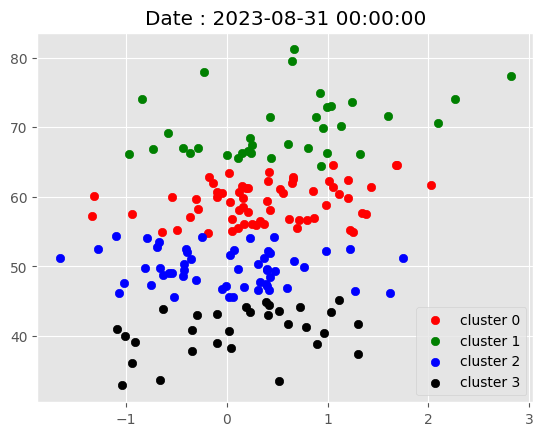

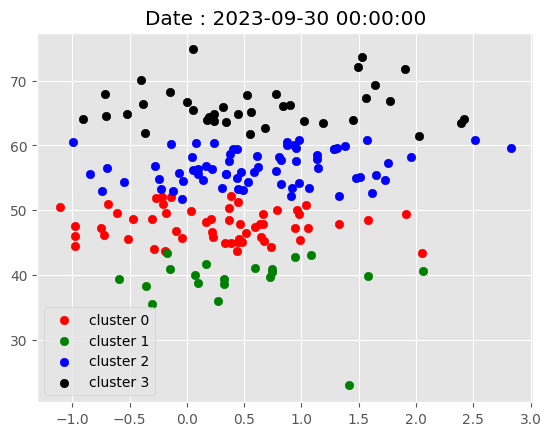

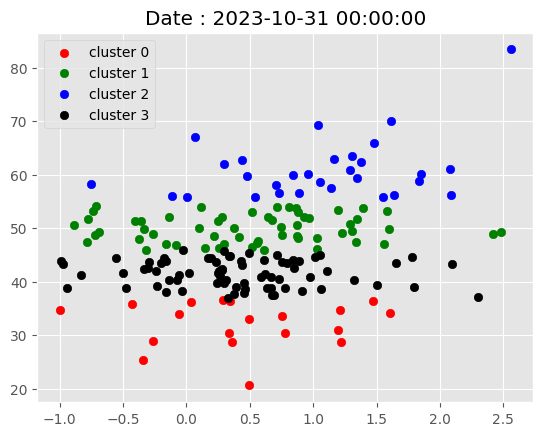

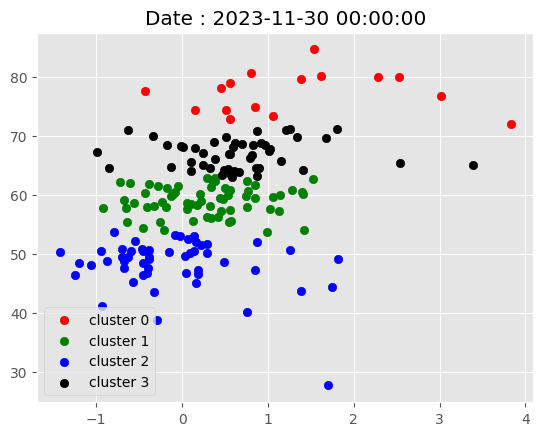

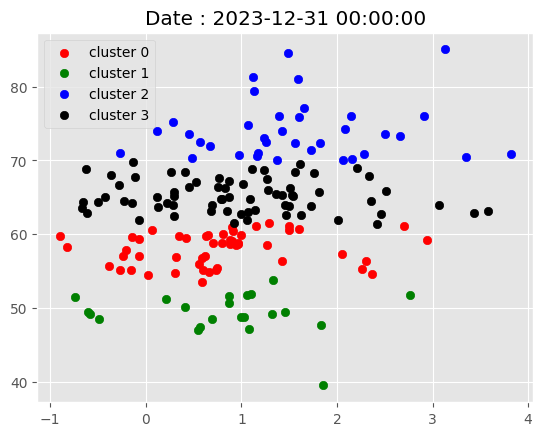

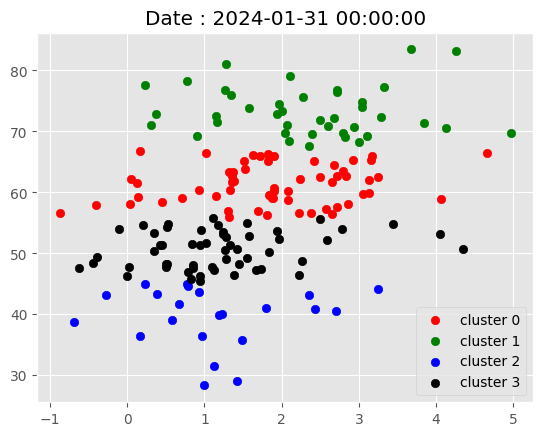

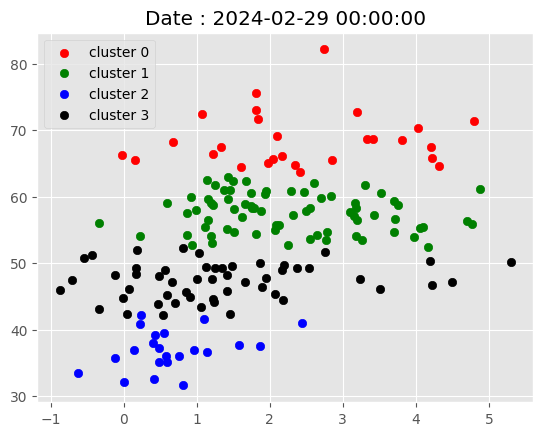

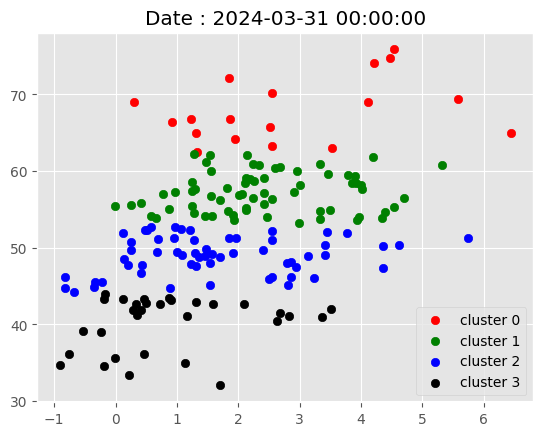

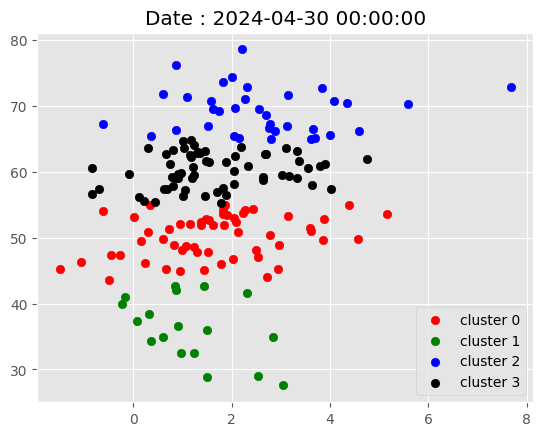

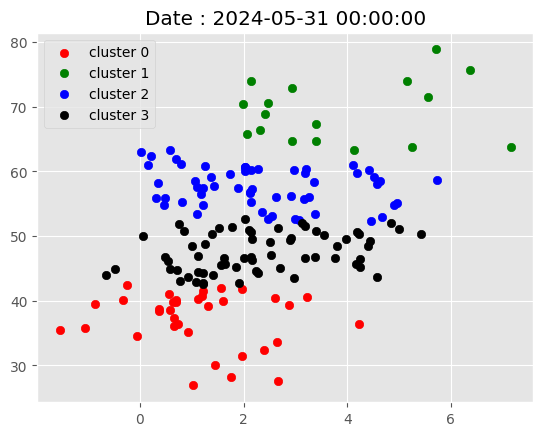

In [128]:
def plot_clusters(data):
    cluster_0 = data[data['cluster']==0 ]
    cluster_1 = data[data['cluster']==1 ]
    cluster_2 = data[data['cluster']==2 ]
    cluster_3 = data[data['cluster']==3 ]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red' , label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green' , label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue' , label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black' , label='cluster 3')

    plt.legend()
    plt.show()
    return 1


plt.style.use('ggplot')
for i in data_new.index.get_level_values('Date').unique().tolist()[-10:]:
    g = data_new.xs(i,level=0)
    plt.title(f"Date : {i}")
    plot_clusters(g)

## Apply pre-defined centroids

In [137]:
# Apply predefined clusters

target_rsi_values =[ 30,45,55,70]

initial_centroids = np.zeros((len(target_rsi_values) , 18))

initial_centroids[:,6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

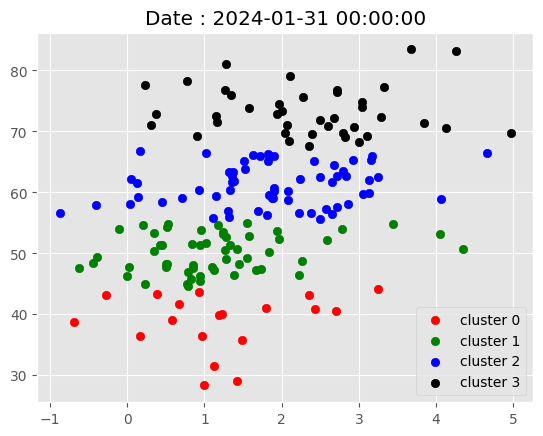

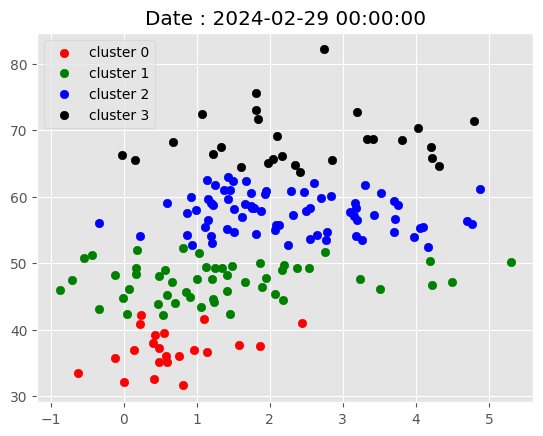

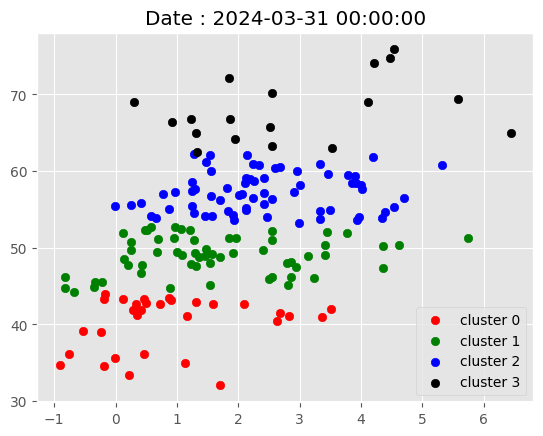

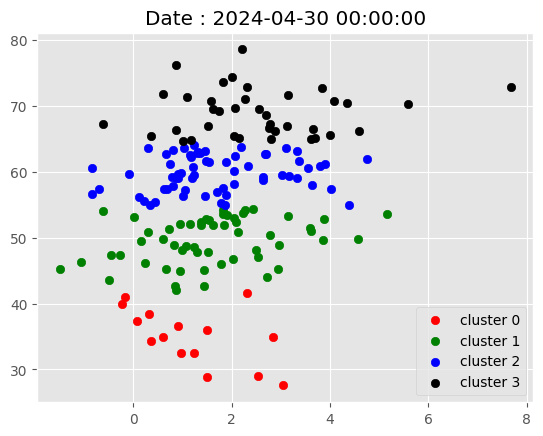

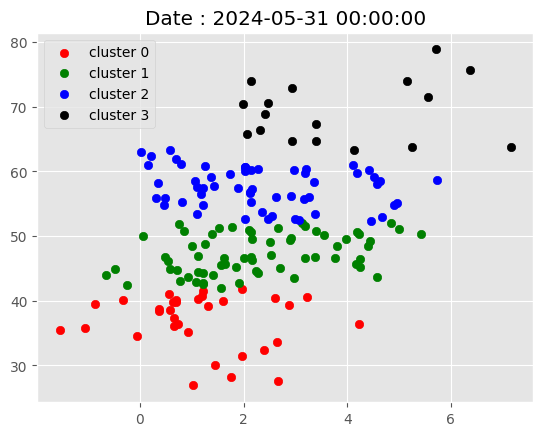

In [141]:
data_new = data_new.dropna().groupby('Date',group_keys=False).apply(get_clusters,initial_centroids)
for i in data_new.index.get_level_values('Date').unique().tolist()[-5:]:
    g = data_new.xs(i,level=0)
    plt.title(f"Date : {i}")
    plot_clusters(g)

## For each month select assets based pn cluster and form a portfolio based on EFFICIENT FRONTIER MAX SHARPE RATIO optimization
- First we filter only stocks corresponding to cluster we choose based on our hypothesis
- Momentum is persistent and my idea would be that stocks clustred around RSI 70 centroid continue to outperform in the following month - thus would select stocks corresponding to cluster 3

In [150]:
filtered_df = data_new[data_new['cluster']==3]

filtered_df.reset_index(level=1,inplace=True)

filtered_df.index= filtered_df.index + pd.DateOffset(1)


filtered_df = filtered_df.reset_index().set_index(['Date','Ticker'])

dates = filtered_df.index.get_level_values('Date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime("%Y-%m-%d")] = filtered_df.xs(d, level =0).index.tolist()



fixed_dates

{'2019-06-01': ['ABB.NS',
  'ADANIENT.NS',
  'ADANIPORTS.NS',
  'AXISBANK.NS',
  'BAJAJFINSV.NS',
  'BAJFINANCE.NS',
  'BEL.NS',
  'BERGEPAINT.NS',
  'BPCL.NS',
  'CENTURYTEX.NS',
  'CHOLAFIN.NS',
  'COALINDIA.NS',
  'CONCOR.NS',
  'CUMMINSIND.NS',
  'FEDERALBNK.NS',
  'HDFCBANK.NS',
  'HINDPETRO.NS',
  'HINDUNILVR.NS',
  'ICICIBANK.NS',
  'IGL.NS',
  'INDHOTEL.NS',
  'INDIANB.NS',
  'IOC.NS',
  'JUSTDIAL.NS',
  'KAJARIACER.NS',
  'KOTAKBANK.NS',
  'LICHSGFIN.NS',
  'LT.NS',
  'MANAPPURAM.NS',
  'MARICO.NS',
  'MUTHOOTFIN.NS',
  'NESTLEIND.NS',
  'PFC.NS',
  'PIDILITIND.NS',
  'PIIND.NS',
  'RAMCOCEM.NS',
  'RCF.NS',
  'SBIN.NS',
  'SHREECEM.NS',
  'SIEMENS.NS',
  'SRF.NS',
  'TATACONSUM.NS',
  'TCS.NS',
  'TITAN.NS',
  'ULTRACEMCO.NS',
  'UPL.NS',
  'VGUARD.NS'],
 '2019-07-01': ['ABB.NS',
  'ADANIPOWER.NS',
  'APOLLOHOSP.NS',
  'AXISBANK.NS',
  'BAJAJFINSV.NS',
  'BAJFINANCE.NS',
  'BATAINDIA.NS',
  'BEL.NS',
  'CANBK.NS',
  'CESC.NS',
  'COFORGE.NS',
  'CONCOR.NS',
  'FEDERALBNK.NS',

## Define portfolio optimization function
- we will define func to optimize portfolio weights using PyPortFolioOpt package and efficient frontier optimizr to maximize the sharpe ratio
- to optimize the weithts of a given portgolio we would need to supply last 1 year prices 
- apply single stock weiht bounds constraint for diversification ( min half of equally weight max 10% of portfolio)

In [167]:
from pypfopt.efficient_frontier import efficient_frontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices,
                     lower_bound=0
                     ):

    returns = expected_returns.mean_historical_return(prices=prices,frequency = 252)


    cov = risk_models.sample_cov(prices=prices,frequency=252)


    ef = efficient_frontier.EfficientFrontier(expected_returns = returns,
                                              cov_matrix= cov , 
                                              weight_bounds= (lower_bound,1),
                                              solver='SCS'
                                              )
    

    weights = ef.max_sharpe()

    return ef.clean_weights()




- Download Fresh daily prices data for short listed stocks

In [154]:
data_new.index.get_level_values('Date')

DatetimeIndex(['2019-05-31', '2019-05-31', '2019-05-31', '2019-05-31',
               '2019-05-31', '2019-05-31', '2019-05-31', '2019-05-31',
               '2019-05-31', '2019-05-31',
               ...
               '2024-05-31', '2024-05-31', '2024-05-31', '2024-05-31',
               '2024-05-31', '2024-05-31', '2024-05-31', '2024-05-31',
               '2024-05-31', '2024-05-31'],
              dtype='datetime64[ns]', name='Date', length=11505, freq=None)

In [156]:
stocks = data_new.index.get_level_values('Ticker').unique().tolist()

new_df = yf.download(tickers=stocks,start=data_new.index.get_level_values('Date').unique()[0] - pd.DateOffset(months=12),
                     end=data.index.get_level_values('Date').unique()[-1]
                      )

new_df

[*********************100%%**********************]  209 of 209 completed

3 Failed downloads:
['TORNTPHARM.NS']: ConnectTimeout(MaxRetryError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v8/finance/chart/%ticker%?period1=1527705000&period2=1717093800&interval=1d&includePrePost=False&events=div%2Csplits%2CcapitalGains&crumb=4BT6egirAGM (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001F7EBE836D0>, 'Connection to query2.finance.yahoo.com timed out. (connect timeout=10)'))"))
['EMAMILTD.NS']: ConnectTimeout(MaxRetryError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v8/finance/chart/%ticker%?period1=1527705000&period2=1717093800&interval=1d&includePrePost=False&events=div%2Csplits%2CcapitalGains&crumb=4BT6egirAGM (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001F7EBECBB50>, 'Connection to query2.finance.yahoo.com time

Price        Adj Close                                                     \
Ticker     AARTIIND.NS       ABB.NS    ABFRL.NS       ACC.NS  ADANIENT.NS   
Date                                                                        
2018-05-31  295.443878  1094.602051  146.180389  1273.310181    76.474754   
2018-06-01  291.431824  1069.721680  143.420410  1247.084473    75.558311   
2018-06-04  284.606598  1053.193970  137.801865  1229.553711    73.472641   
2018-06-05  278.006897  1031.779175  137.111877  1207.934082    72.935432   
2018-06-06  274.386475  1063.101562  140.315430  1236.979614    74.736694   
...                ...          ...         ...          ...          ...   
2024-05-13  668.950012  7984.250000  254.050003  2363.750000  2879.600098   
2024-05-14  653.000000  8080.850098  258.549988  2463.500000  3037.550049   
2024-05-15  621.900024  8084.299805  263.049988  2489.149902  3049.750000   
2024-05-16  628.349976  8305.150391  263.149994  2486.100098  3041.649902   
2024-05-17  628.299988  8371.349609  265.000000  2521.949951  3060.500000   

Price                                                              \
Ticker     ADANIPORTS.NS ADANIPOWER.NS AJANTPHARM.NS     ALKEM.NS   
Date                                                                
2018-05-31    377.856262     20.150000    605.202087  1808.397461   
2018-06-01    373.472137     19.600000    591.555420  1822.501587   
2018-06-04    364.751953     18.450001    584.857849  1824.624268   
2018-06-05    359.982452     17.500000    575.267395  1800.425781   
2018-06-06    362.102234     18.250000    573.286499  1836.275513   
...                  ...           ...           ...          ...   
2024-05-13   1306.400024    594.900024   2380.250000  5210.450195   
2024-05-14   1331.250000    628.049988   2438.250000  5183.200195   
2024-05-15   1337.849976    639.750000   2394.899902  5246.950195   
2024-05-16   1345.050049    640.349976   2395.250000  5318.049805   
2024-05-17   1335.699951    635.950012   2381.050049  5437.700195   

Price                    ...       Volume                                \
Ticker     AMBUJACEM.NS  ... UNIONBANK.NS    UPL.NS   VEDL.NS VGUARD.NS   
Date                     ...                                              
2018-05-31   183.504166  ...      6148106   5708037  29327091   4811647   
2018-06-01   181.851364  ...      6694445   1222384  18640874   3264257   
2018-06-04   179.975220  ...      4666827    863778  11484275   1522461   
2018-06-05   180.511276  ...      5512685   1200031   8543831   2482400   
2018-06-06   182.387405  ...      7597132   1291956  19831399   1021375   
...                 ...  ...          ...       ...       ...       ...   
2024-05-13   588.200012  ...     33666442  27039443  10884162    523787   
2024-05-14   610.200012  ...     17206316  15011896  22195946    318210   
2024-05-15   613.250000  ...     19140585   4234215  20115791   2275114   
2024-05-16   615.400024  ...     16210090   2398088  16155897   1295108   
2024-05-17   620.700012  ...     11476703   1910642  13364381    753583   

Price                                                                     
Ticker     VIPIND.NS VOLTAS.NS WIPRO.NS YESBANK.NS  ZEEL.NS ZYDUSLIFE.NS  
Date                                                                      
2018-05-31    395679   1347553      NaN   17910411  5696521      3116812  
2018-06-01    369193    860163      NaN    9470256   842901       862303  
2018-06-04   1123318    598601      NaN   14501600  1328975      1306674  
2018-06-05    499934   1832843      NaN    8492155  2846864       666265  
2018-06-06    753164   3796941      NaN    8211104  3910943      1367479  
...              ...       ...      ...        ...      ...          ...  
2024-05-13   1077389   2142147      NaN  260499591  7114440      1082684  
2024-05-14    294831   1943532      NaN  181551079  8313748       799850  
2024-05-15    186343    621432      NaN  150206482  7856069      1174315  
202

In [157]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
returns_dataframe


Ticker,AARTIIND.NS,ABB.NS,ABFRL.NS,ACC.NS,ADANIENT.NS,ADANIPORTS.NS,ADANIPOWER.NS,AJANTPHARM.NS,ALKEM.NS,AMBUJACEM.NS,...,UNIONBANK.NS,UPL.NS,VEDL.NS,VGUARD.NS,VIPIND.NS,VOLTAS.NS,WIPRO.NS,YESBANK.NS,ZEEL.NS,ZYDUSLIFE.NS
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01,-0.013673,-0.022992,-0.019061,-0.020812,-0.012056,-0.011670,-0.027675,-0.022807,0.007769,-0.009048,...,-0.016676,-0.014018,-0.000202,-0.055402,-0.021708,-0.013143,NaN,-0.010161,0.004038,-0.023241
2018-06-04,-0.023698,-0.015571,-0.039963,-0.014157,-0.027992,-0.023626,-0.060465,-0.011387,0.001164,-0.010370,...,-0.018100,-0.016327,-0.006060,-0.020799,-0.000970,-0.000188,NaN,0.008639,0.003487,-0.002837
2018-06-05,-0.023462,-0.020543,-0.005020,-0.017740,-0.007339,-0.013162,-0.052864,-0.016534,-0.013351,0.002974,...,-0.006873,-0.001093,-0.002029,-0.030016,-0.002552,-0.027785,NaN,-0.018244,-0.028791,-0.009993
2018-06-06,-0.013108,0.029906,0.023096,0.023761,0.024397,0.005871,0.041964,-0.003449,0.019716,0.010340,...,0.038336,0.011383,0.000812,0.014748,0.022854,0.023270,NaN,0.007102,0.012052,0.004152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-13,-0.005516,0.106401,-0.010961,0.001524,0.029015,0.030821,-0.013690,0.001198,0.015775,0.010940,...,-0.040235,0.062182,0.008124,-0.002823,-0.034990,0.011045,NaN,-0.011173,-0.011109,0.010483
2024-05-14,-0.024132,0.012026,0.017558,0.041334,0.053400,0.018843,0.054226,0.024075,-0.005244,0.036720,...,-0.020367,-0.046074,0.043711,0.002400,-0.015421,0.001803,NaN,0.013393,0.014532,-0.008957
2024-05-15,-0.048798,0.000427,0.017255,0.010358,0.004008,0.004945,0.018458,-0.017939,0.012224,0.004986,...,0.038890,0.009270,0.011150,0.034104,0.005860,-0.000575,NaN,0.002215,-0.006857,0.013531


In [215]:
portfolio_df = pd.DataFrame()


for start_date in fixed_dates.keys():
    
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime("%Y-%m-%d")
        
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime("%Y-%m-%d")

        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime("%Y-%m-%d")

        # print(start_date,end_date,optimization_start_date,optimization_end_date)

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:

            weights = optimize_weights(prices=optimization_df,
                                lower_bound=round(1/(len(optimization_df.columns)*2),3))


            weights = pd.DataFrame(weights,index=pd.Series(0))

            success = True
        except:
            print(f"Max Sharpe Optimization failed for {start_date} to {end_date}. Go with equal weights.")


        if success == False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for _ in range (len(optimization_df.columns))] ,
                                    index= optimization_df.columns.tolist(),
                                    columns = pd.Series(0)
                                    ).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                .merge(weights.stack().to_frame('weight').reset_index(level=0,drop=True),
                    left_index=True,right_index=True).reset_index().set_index(['Date','index']).unstack().stack()
        
        temp_df.index.names=['Date','Ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']


        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('StrategyReturn')
                                        
        portfolio_df = pd.concat([portfolio_df,temp_df],axis =0)
    
    except Exception as e:
        print(e)
        print(f"Error occured for {start_date} , {end_date}")
        continue


portfolio_df =portfolio_df.drop_duplicates()



Max Sharpe Optimization failed for 2019-08-01 to 2019-08-31. Go with equal weights.
Max Sharpe Optimization failed for 2019-09-01 to 2019-09-30. Go with equal weights.
Max Sharpe Optimization failed for 2019-12-01 to 2019-12-31. Go with equal weights.
Max Sharpe Optimization failed for 2020-03-01 to 2020-03-31. Go with equal weights.
Max Sharpe Optimization failed for 2020-04-01 to 2020-04-30. Go with equal weights.
Max Sharpe Optimization failed for 2020-06-01 to 2020-06-30. Go with equal weights.
Max Sharpe Optimization failed for 2020-08-01 to 2020-08-31. Go with equal weights.
Max Sharpe Optimization failed for 2020-09-01 to 2020-09-30. Go with equal weights.
Max Sharpe Optimization failed for 2020-10-01 to 2020-10-31. Go with equal weights.
Max Sharpe Optimization failed for 2020-12-01 to 2020-12-31. Go with equal weights.
Max Sharpe Optimization failed for 2021-01-01 to 2021-01-31. Go with equal weights.
Max Sharpe Optimization failed for 2021-02-01 to 2021-02-28. Go with equal w

In [217]:
portfolio_df.index.unique()

DatetimeIndex(['2019-06-03', '2019-06-04', '2019-06-06', '2019-06-07',
               '2019-06-10', '2019-06-11', '2019-06-12', '2019-06-13',
               '2019-06-14', '2019-06-17',
               ...
               '2024-05-06', '2024-05-07', '2024-05-08', '2024-05-09',
               '2024-05-10', '2024-05-13', '2024-05-14', '2024-05-15',
               '2024-05-16', '2024-05-17'],
              dtype='datetime64[ns]', name='Date', length=1226, freq=None)

In [222]:
nifty_ticker = '^NSEI'

nifty_df = yf.download(nifty_ticker,start='2019-06-03',end= '2024-05-17')

nifty_return = np.log(nifty_df[['Adj Close']] ).diff().dropna().rename(columns={'Adj Close':'nifty_50'})

portfolio_df = portfolio_df.merge(nifty_return,left_index=True,right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,StrategyReturn,nifty_50
Date,,
2019-06-04,-0.002880,-0.005549
2019-06-06,-0.016838,-0.014909
2019-06-07,-0.001810,0.002269
2019-06-10,0.008166,0.004375
2019-06-11,0.006970,0.003592
...,...,...
2024-05-10,0.013427,0.004440
2024-05-13,0.003441,0.002213
2024-05-14,0.015437,0.005135


AttributeError: 'AxesSubplot' object has no attribute 'yaxis_set_major_formatter'

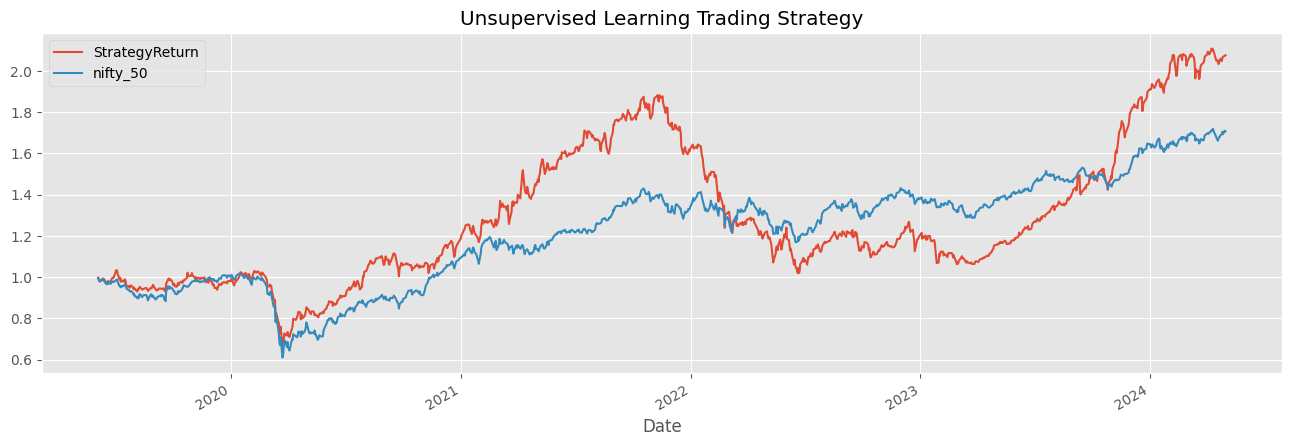

In [234]:
plt.style.use('ggplot')

import matplotlib.ticker as mtick
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())

portfolio_cumulative_return['2017-01-01':'2024-05-01'].plot(figsize=(16,5))

plt.title('Unsupervised Learning Trading Strategy')

plt.gca().yaxis_set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()